## Cargar repositorio en Colab
<a href="https://colab.research.google.com/github/iiap-gob-pe/PalmsCNN/blob/main/1.PalmsCNN_Tutorial_Google_Colab.ipynb" target="_blank">Abrir cuaderno en Google Colab</a>

In [ ]:
!git clone https://github.com/iiap-gob-pe/PalmsCNN.git
!mv PalmsCNN/* .
!mv PalmsCNN/.* .
!rm -rf PalmsCNN

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from osgeo import gdal, ogr
import rasterio.features
import numpy as np
import matplotlib.pyplot as plt
import fiona
import warnings
warnings.filterwarnings('ignore')

# Palms CNN 
This guide provides a step-by-step walkthrough of how we trained a model to segment the crowns of three palm species in the Amazonian forests using RGB drone imagery. 
This code belongs to:
Tagle et al. (in review) .'Overcoming the Research-Implementation Gap through Drone-based Mapping of Economically Important Amazonian Palms'

Our approach combines drone-based data with the ecoCNN data generation with the DeepLabv3+ and DWT architecture.

## 0. Preempting common package issues

Some users occasionally have difficulties with a few of the required packages.  Here are a few tips that may come in handy:</br>

### gdal problems
Some users occasionally have issues getting gdal to work with jupyer notebooks.  If you're getting exceptions thrown during this tutorial with regards to projection issues, you can set the ignore_projections flag below to True - this is not a longterm solution, but if you're just trying to get through this notebook, it'll do.

In [2]:
ignore_projections=True

### tensorflow issues on some mac versions

Some mac users report some issues with libiomp5 (e.g. this thread https://github.com/dmlc/xgboost/issues/1715) - an easy workaround seems to be the following line:





In [9]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 1. Training Data Preparation for the Palm Species Mapping (Semantic Segmentation Classification)¶
A clean and accurate dataset is crucial for training our model. We used multi-resolution crown delineation from: https://github.com/xime377/UAV-classification and triple-checked that each crown corresponded to the correct palm species. 

Once the dataset was refined, we adapted the Training Data Preparation methodology from https://github.com/pgbrodrick/ecoCNN

### 1.1 Data Preparation - Checking the data
We start by verifying that our UAV images align correctly with the corresponding shapefiles for the assigned species.

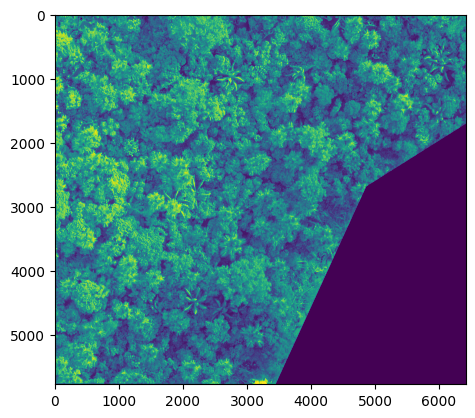

In [3]:
from Palms_Segment import generate_training_data
from osgeo import gdal, ogr
import rasterio.features
import numpy as np
import matplotlib.pyplot as plt
import fiona
import random

import plot_utility

###Import drone image
feature = gdal.Open('/data/DMM-02_1.tif',gdal.GA_ReadOnly)
#feature = gdal.Open('/data/AGU-01_crop.tif',gdal.GA_ReadOnly)

# Check if the raster is loaded successfully
if feature is None:
    raise FileNotFoundError("Could not open the raster file. Check the file path.")

## Get the geotransform to properly locate the raster 
geotransform = feature.GetGeoTransform()

## Read the Green band (Band 2) as an example
green_band = feature.GetRasterBand(2).ReadAsArray().astype(np.uint8)


# Compute the extent of the raster (left, right, bottom, top) in map coordinates
xmin = geotransform[0]
xmax = xmin + geotransform[1] * feature.RasterXSize
ymax = geotransform[3]
ymin = ymax + geotransform[5] * feature.RasterYSize
extent = [xmin, xmax, ymin, ymax]

# Plot the raster image 
plt.imshow(green_band)
plt.show() #plot the image in the notebook explicitly 

Now that we can see the drone image, we will verify that the shapefiles generated overlap the palms.

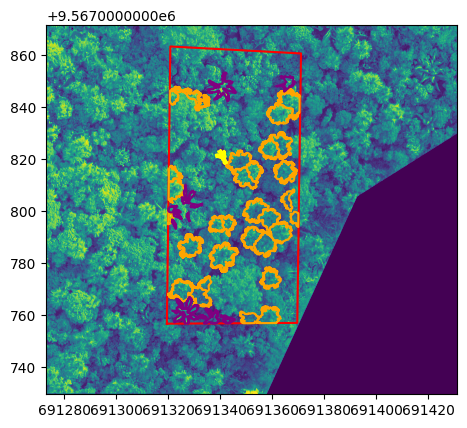

In [4]:
### Plot each shapefile on top of the raster
# Function to plot shapefiles on top of the raster
def plot_shapefile(shapefile_path, color='red', label=None):
    # Open the shapefile using Fiona
    with fiona.open(shapefile_path, 'r') as shapefile:
        for feature in shapefile:
            geom = feature['geometry']
            if geom['type'] == 'Polygon':
                for coords in geom['coordinates']:
                    if isinstance(coords[0][0], (float, int)):  # Check if the coordinates are not empty
                        x, y = zip(*coords)
                        plt.plot(x, y, color=color, label=label)
            elif geom['type'] == 'MultiPolygon':
                for polygon in geom['coordinates']:
                    for coords in polygon:
                        if isinstance(coords[0][0], (float, int)):  # Check if the coordinates are not empty
                            x, y = zip(*coords)
                            plt.plot(x, y, color=color, label=label)
            elif geom['type'] == 'Point':
                x, y = geom['coordinates']
                plt.scatter(x, y, color=color, label=label)


### Plot each shapefile on top of the raster
##Import the shapefiles (We recommend working with geopackages nowadays)
boundary_shapefile = '/data/DMM02_ROI_2019.shp' 
aguaje = '/data/Mflexuosa_DMM02_2019.shp'
euterpe = '/data/Eprecatoria_DMM02_2019.shp'
oenocarpus = '/data/Obataua_DMM02_2019.shp'

# Plot the raster image with correct extent
plt.imshow(green_band, extent=extent)

#Let's plot them on top of the UAV mosaic
plot_shapefile(boundary_shapefile, color='red', label='Boundary')
plot_shapefile(aguaje, color='orange', label='Aguaje')
plot_shapefile(euterpe, color='yellow', label='Euterpe')
plot_shapefile(oenocarpus, color='purple', label='Oenocarpus')

# Show the plot
plt.show()

### 1.2 Data Preparation - Arranging the data
The next step involves rasterizing the shapefiles. 
The UAV mosaics will be designated as "Features," the regions of interest (ROIs) will be referred to as "Boundaries," and the shapefiles representing the three species will be termed "Responses." 
In the following scripts, we will work with multiple datasets, enabling us to load several files simultaneously as a list for greater efficiency. Consequently, the variable name for the features will be updated to "Feature_file_list," and similar adjustments will be made for the other datasets.

In [5]:
### Define rasterize function
#import packages
import sys,os
import re

def rasterize_vector(vector_file,geotransform,output_shape):
    """ Rasterizes an input vector directly into a numpy array.

    Arguments:
    vector_file - str
      Input vector file to be rasterized.
    geotransform - list
      A gdal style geotransform.
    output_shape - tuple
      The shape of the output file to be generated.

    Return:
    A rasterized 2-d numpy array.
    """
    ds = fiona.open(vector_file,'r')
    geotransform = [geotransform[1],geotransform[2],geotransform[0],geotransform[4],geotransform[5],geotransform[3]]
    mask = np.zeros(output_shape)
    for n in range(0,len(ds)):
      rasterio.features.rasterize([ds[n]['geometry']],transform=geotransform,default_value=1,out=mask)
    return mask

In [6]:
### Apply function

### Load data
#UAV mosaics
feature_file_list = ['/data/DMM-02_1.tif'] 
dataset = gdal.Open(feature_file_list[0],gdal.GA_ReadOnly)#Reading all the images --> dataset
print(dataset)

#Crowns shapefiles
response_file_list = ['/data/Mflexuosa_DMM02_2019.shp',
                      '/data/Eprecatoria_DMM02_2019.shp',
                    '/data/Obataua_DMM02_2019.shp'
                     ]

### Output folder
out_folder = '/results/Palms_Segment/responses_raster' #do not forget to create the folder if it does not exist
os.makedirs(out_folder, exist_ok=True) # Create the folder if it doesn't exist

#Run the function
response = np.zeros((dataset.RasterYSize,dataset.RasterXSize))

for i in range(0,len(response_file_list)):
    aux = rasterize_vector(response_file_list[i],dataset.GetGeoTransform(),[dataset.RasterYSize,dataset.RasterXSize])#rasterize the response
    response = response + aux*(i+1)

output_tif_file = os.path.join(out_folder, 'Palms_merged_'+ os.path.basename(feature_file_list[0]).split('.')[0]  + '_classes.tif')

driver = gdal.GetDriverByName('GTiff')
outrgb = driver.Create(output_tif_file,dataset.RasterXSize,dataset.RasterYSize,1,gdal.GDT_Float32)
outrgb.SetProjection(dataset.GetProjection())
outrgb.SetGeoTransform(dataset.GetGeoTransform())
outrgb.GetRasterBand(1).WriteArray(response[:,:],0,0)
del outrgb
print ("***********Rasters saved, check folder", out_folder, "********************")

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f9baecaa390> >
***********Rasters saved, check folder /results/Palms_Segment/responses_raster ********************


## 1.3 Generating Training Data for the Palm Species Mapping (Semantic Segmentation Classification)
This section provides a visual approach to selecting the optimal method for generating training data. For the actual generation of training data, please execute the Python script /Palms_Segment/1.build_TrainingData.py 
For more information regarding the function refer to the SI of [Uncovering ecological patterns with convolutional neural networks](https://www.sciencedirect.com/science/article/pii/S0169534719300862?via%3Dihub)

In [7]:
from Palms_Segment import generate_training_data

# Tile size selection: 
"""You can experiment with different tile sizes to see how well your object 
of interest is represented. It’s recommended to ensure that the object appears
at least once or twice within the tile. For the palm species, we found that a 
tile size of 256 works best. Larger tile sizes may increase processing time. 
It's advisable to use sizes in exponential increments
"""

window_radius = 64

#Select the number of tiles per UAV mosaic
"""Depending on your dataset, specify how many tiles you would like to extract 
from each UAV mosaic. The specified value indicates the maximum retrieved per mosaic.
"""
samples_per_response_per_site = 100 #We worked with 191 for 3 species and 170 when only testing one class


# List of mosaics 
feature_file_list = [ '/data/DMM-02_1.tif',
#                     '/data/AGU-01_crop.tif',
#                     '/data/PRN-01_01.tif',

	]

# Rasters with the response data (the function supports shapefiles directly but only when working with one class)
response_file_list = ['/results/Palms_Segment/responses_raster/Palms_merged_DMM-02_1_classes.tif',
#                      'responses_raster/Palms_AGU-01_crop_classes.tif',
#                      'responses_raster/Palms_PRN-01_01_classes.tif',

	] 

# Shapefile with the Area of Interest (ROI)
boundary_file_list = ['/data/DMM02_ROI_2019.shp',
#                      '/data/PRN01_ROI_2017.shp',
	]

#Prepare training data: 4dimensional data arrays with dimensions (number of samples, y, x, number of features) and (number of samples, y, x, number of responses)
generate_training_data.build_semantic_segmentation_training_data(
                                      window_radius,
                                      samples_per_response_per_site,
                                      feature_file_list,
                                      response_file_list,
									  response_vector_flag=False, #True when working with vectors (only one class)
									  boundary_file_list=boundary_file_list,
									  boundary_file_vector_flag=True, #True when using ROIs
									  ignore_projections=ignore_projections,
									  verbose=True, #False to have no output printing 
									  )
 
print("======>Finished")

File: /data/DMM02_ROI_2019.shp
Pos: 0
(5773, 6418, 4)
/data/DMM-02_1.tif class [1. 2. 3. 4.]
(1752857, 'response locations potentially available')
(7031, 'response locations potentially available')
(234982, 'response locations potentially available')
(23, 'response locations potentially available')
('feature shape', (92, 128, 128, 4))
('name_responses shape', (92,))
('response shape', (92, 128, 128, 1))
========= Generating  92  Tiles=========
======>Finished


**Let's plot the generated data.** Each tile should contain at least one of the palm species classes:

- Background (Class 0)
- *Mauritia Flexuosa* (Class 1)
- *Euterpe Precatoria* (Class 2)
- *Oenocarpus Bataua* (Class 3)

We will only plot the first 5 that were saved in the folders:

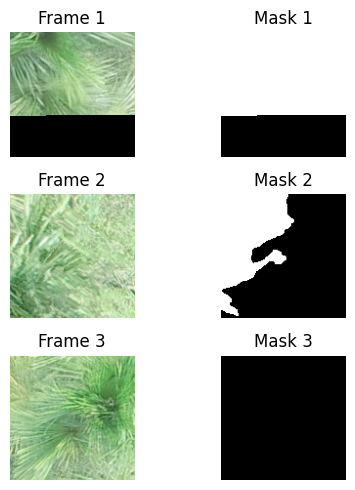

In [8]:
import plot_utility
import os
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import numpy as np

# Define the paths to the frames and masks directories
train_frame_path = '/results/Palms_Segment/dataset/frames/'
train_mask_path = '/results/Palms_Segment/dataset/masks/'

###Plot the first 3 images generated
plot_utility.plot_saved_images(train_frame_path, train_mask_path, num_images=3, delete_after_plot=True)

We didn't apply any scaling when initially building our training data. What impact would it have if we mean-center the data? Let’s explore how the data looks when we adjust it to have a mean of zero, potentially improving model performance by standardizing feature values

File: /data/DMM02_ROI_2019.shp
Pos: 0
(5773, 6418, 4)
/data/DMM-02_1.tif class [1. 2. 3. 4.]
(1752857, 'response locations potentially available')
(7031, 'response locations potentially available')
(234982, 'response locations potentially available')
(23, 'response locations potentially available')
('feature shape', (92, 128, 128, 4))
('name_responses shape', (92,))
('response shape', (92, 128, 128, 1))
========= Generating  92  Tiles=========


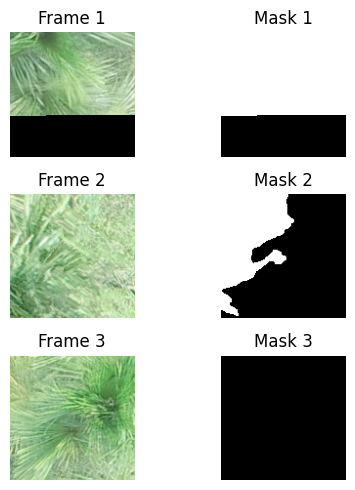

In [9]:
generate_training_data.build_semantic_segmentation_training_data(
                                      window_radius,
                                      samples_per_response_per_site,
                                      feature_file_list,
                                      response_file_list,
									  response_vector_flag=False, #True when working with vectors (only one class)
									  boundary_file_list=boundary_file_list,
									  boundary_file_vector_flag=True, #True when using ROIs
									  ignore_projections=ignore_projections,
									  local_scale_flag='mean', #scaling
                                      verbose=True, #False to have no output printing 
									  )


###Plot the first 3 images generated
plot_utility.plot_saved_images(train_frame_path, train_mask_path, num_images=3, delete_after_plot=True)

It looks better, but what happens if we increase the window_radius? By enlarging the tile size, we can capture even more context around each palm crown

File: /data/DMM02_ROI_2019.shp
Pos: 0
(5773, 6418, 4)
/data/DMM-02_1.tif class [1. 2. 3. 4.]
(1752857, 'response locations potentially available')
(7031, 'response locations potentially available')
(234982, 'response locations potentially available')
(23, 'response locations potentially available')
('feature shape', (92, 512, 512, 4))
('name_responses shape', (92,))
('response shape', (92, 512, 512, 1))
========= Generating  92  Tiles=========


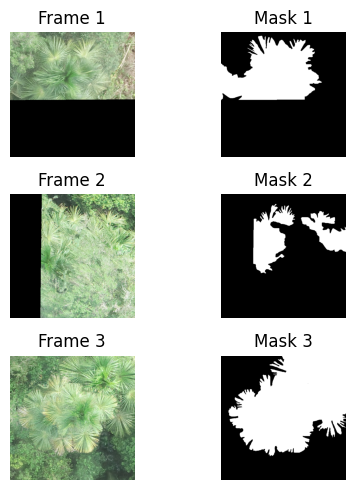

In [10]:
window_radius = 256 #We worked with 256, higher is computationally demanding
generate_training_data.build_semantic_segmentation_training_data(
                                      window_radius,
                                      samples_per_response_per_site,
                                      feature_file_list,
                                      response_file_list,
									  response_vector_flag=False, #True when working with vectors (only one class)
									  boundary_file_list=boundary_file_list,
									  boundary_file_vector_flag=True, #True when using ROIs
									  ignore_projections=ignore_projections,
									  local_scale_flag='mean', #scaling
                                      verbose=True, #False to have no output printing 
									  )

###Plot the first 3 images generated
plot_utility.plot_saved_images(train_frame_path, train_mask_path, num_images=3, delete_after_plot=True)

By increasing the tile size, we can now capture more palm crowns within a single tile, providing additional context for the model. However, since our region of interest (ROI) is relatively small, a significant portion of each tile is dominated by 'nodata' values. To address this, we can adjust the nodata_maximum_fraction to a value lower than the default 0.5. This could help the model focus on more meaningful data by reducing the influence of areas with no information

File: /data/DMM02_ROI_2019.shp
Pos: 0
(5773, 6418, 4)
/data/DMM-02_1.tif class [1. 2. 3.]
(1614498, 'response locations potentially available')
(96, 100, 96)
(7031, 'response locations potentially available')
(100, 100, 200)
(235005, 'response locations potentially available')
(90, 100, 290)
('feature shape', (300, 512, 512, 4))
('name_responses shape', (300,))
('response shape', (300, 512, 512, 1))
========= Generating  300  Tiles=========


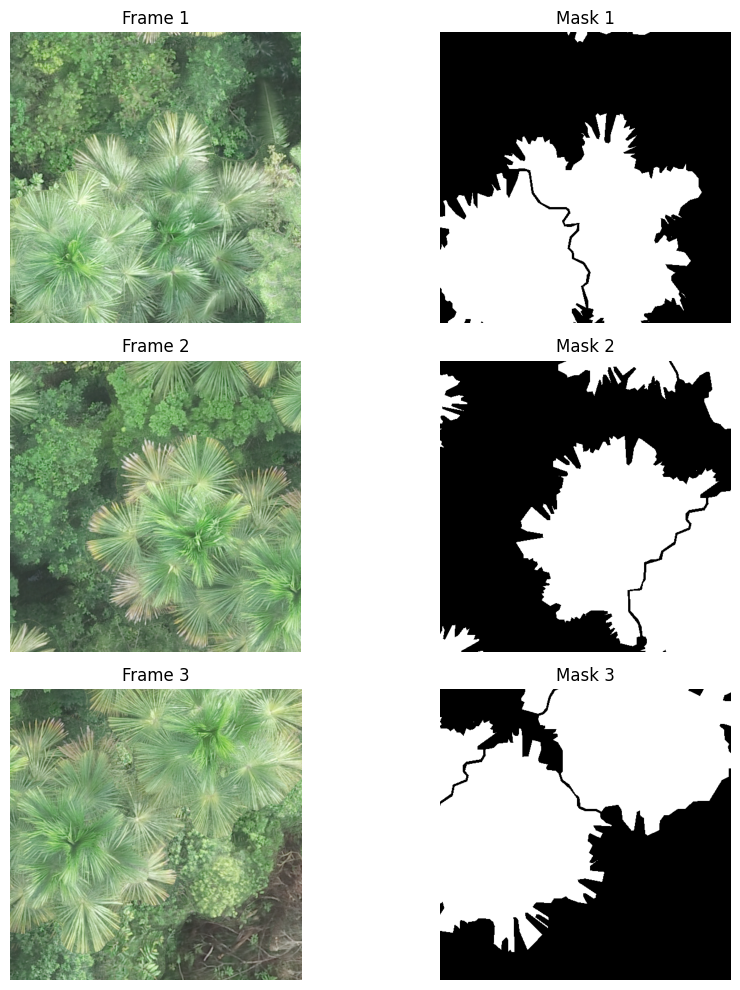

In [18]:
generate_training_data.build_semantic_segmentation_training_data(
                                      window_radius,
                                      samples_per_response_per_site,
                                      feature_file_list,
                                      response_file_list,
									  response_vector_flag=False, #True when working with vectors (only one class)
									  boundary_file_list=boundary_file_list,
									  boundary_file_vector_flag=True, #True when using ROIs
									  ignore_projections=ignore_projections,
									  local_scale_flag='mean', #scaling
									  nodata_maximum_fraction=0.4,
                                      verbose=True, #False to have no output printing 
									  )

###Plot the first 3 images generated
plot_utility.plot_saved_images(train_frame_path, train_mask_path, num_images=3, delete_after_plot=True)

While our  work used a large dataset that didn’t require these techniques, there are situations—like in this example—where sample sizes may be insufficient. This function offers two effective methods to increase the number of training samples. First, by employing center_random_offset_fraction, we can randomly shift each instance slightly, which diversifies the dataset. Additionally, the responses_repeats integer enables us to sample from each response center multiple times, further augmenting the training dataset. In our case, to enrich our dataset, we used image augmentation techniques. They will be explained later.

File: /data/DMM02_ROI_2019.shp
Pos: 0
(5773, 6418, 4)
/data/DMM-02_1.tif class [1. 2. 3. 4.]
(1752857, 'response locations potentially available')
(7031, 'response locations potentially available')
(234982, 'response locations potentially available')
(23, 'response locations potentially available')
('feature shape', (92, 512, 512, 4))
('name_responses shape', (92,))
('response shape', (92, 512, 512, 1))
========= Generating  92  Tiles=========


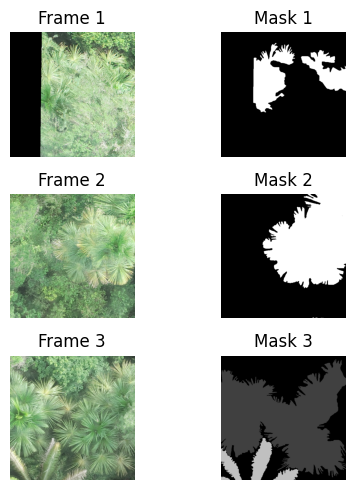

In [11]:
# Offset the window to relocate the response -> not having the response centered, increase overall sample size 
internal_window_radius = int(round(window_radius*0.75))

generate_training_data.build_semantic_segmentation_training_data(
                                      window_radius,
                                      samples_per_response_per_site,
                                      feature_file_list,
                                      response_file_list,
									  response_vector_flag=False, #True when working with vectors (only one class)
									  boundary_file_list=boundary_file_list,
									  boundary_file_vector_flag=True, #True when using ROIs
									  internal_window_radius=internal_window_radius,
									  fill_in_feature_data=True,
									  ignore_projections=ignore_projections,
									  local_scale_flag='mean', #scaling
                                      nodata_maximum_fraction=0.4,
                                      center_random_offset_fraction=0.0, 
                                      response_minimum_fraction=0.0,#0.5
									  response_repeats=1, # To sample from each response center n times
									  random_seed=13, #for reproducibility
									  n_folds=10,
									  verbose=True, #False to have no output printing 
									  savename='test') #Default None

###Plot the first 3 images generated
plot_utility.plot_saved_images(train_frame_path, train_mask_path, num_images=3, delete_after_plot=False)

## 1.3 Splitting our Dataset into Training (80%) and Validation (20%)
To evaluate the accuracy and generalization of our model, we split the dataset into seven combinations of tiles to ensure the trained model could handle the diverse characteristics associated with UAV data collection and geographical locations. These characteristics include factors such as illumination conditions, mosaic spatial resolution, and floristic composition (see manuscript, Table 1, for more details). We applied an 80/20 split, with 80% of the data used for training and 20% for validation, to test model performance across varied conditions. The images stored in the folders were compiled into a list that serves as input for model training. 
To generate the same combinations we made, please run script /Palms_Segment/2.generate_lists_R.py

In [12]:
import fnmatch, os
import numpy as np
import cv2


path="/results/Palms_Segment/dataset/"
n = fnmatch.filter(os.listdir(train_frame_path), "*.png") # include dot-files
print('Images: ',len(n))

def split_train_val(list_tiles):
	### Split dataset (80/20)
	TRAINING_SPLIT = 0.8 #80%
	VAL_SPLIT=0.2
	TEST_SPLIT=0.0  # Independent dataset

	it = int(len(list_tiles) * TRAINING_SPLIT)
	iv = int(len(list_tiles) * VAL_SPLIT)
	itt = int(len(list_tiles) * TEST_SPLIT)
	print('it:',it,' - iv',iv,' itt:',itt)

	#n = np.random.permutation(n)

	listtrain=list_tiles[0:it]
	listval=list_tiles[it:]
	return listtrain,listval


def generarlistfromfilter(listmask):
	list_tiles1=[]
	list_tiles2=[]
	list_tiles3=[]
	for mask in listmask:
		imgmask = cv2.imread(train_mask_path+'/'+mask, cv2.IMREAD_GRAYSCALE)#read grey scale (1D)
		uqclases=np.unique(imgmask)

		if 3 in uqclases:
			list_tiles3.append(mask)
		elif 2 in uqclases:
			list_tiles2.append(mask)
		elif 1 in uqclases:
			list_tiles1.append(mask)
	min_size = min(len(list_tiles1), len(list_tiles2), len(list_tiles3))
	#min_size=6000
	print("class 1",len(list_tiles1))
	print("class 2",len(list_tiles2))
	print("class 3",len(list_tiles3))
	print("min_size",min_size)
	np.random.shuffle(list_tiles1)
	np.random.shuffle(list_tiles2)
	np.random.shuffle(list_tiles3)
	list_tiles1=list_tiles1[0:min_size]
	list_tiles2=list_tiles2[0:min_size]
	list_tiles3=list_tiles3[0:min_size]

	listtrain1,listval1=split_train_val(list_tiles1)
	listtrain2,listval2=split_train_val(list_tiles2)
	listtrain3,listval3=split_train_val(list_tiles3)
	
	b_listtrain = listtrain1+listtrain2+listtrain3
	b_listval= listval1+listval2+listval3
	np.random.shuffle(b_listtrain)
	np.random.shuffle(b_listval)
	return b_listtrain,b_listval

#Reduce training data size for faster demo training
n=n[0:50]
listtrain,listval = generarlistfromfilter(n)

print("listtrain",len(listtrain))
print("listval",len(listval))

###Save as a text file
np.savetxt(path+'trainlist.txt', listtrain, delimiter='\\n',fmt='%s')
np.savetxt(path+'vallist.txt', listval, delimiter='\\n',fmt='%s')


Images:  92
class 1 7
class 2 13
class 3 30
min_size 7
it: 5  - iv 1  itt: 0
it: 5  - iv 1  itt: 0
it: 5  - iv 1  itt: 0
listtrain 15
listval 6


## 2. Model Training - Palm Species Mapping (Semantic Classification)
Now that we have prepared our training data, we will train the model using the DeepLab v3+ architecture. This architecture employs MobileNet-v2 as its backbone and utilizes atrous spatial pyramid pooling (ASPP), which expands the receptive field of the filters. This allows the model to capture multi-scale contextual information, improving its ability to recognize features across varying spatial dimensions.
We followed the code from: https://github.com/bonlime/keras-deeplab-v3-plus
To run it with more data please run script /Palms_Segment/3.train_Palms.py

In [13]:
import numpy as np
import tensorflow as tf
tf.compat.v1.enable_eager_execution() 

from tensorflow.keras import optimizers 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import os

import datetime
import cv2
from math import sqrt
import imageio

# Import Deeplabv3 and utilities from Palms_Segment module
from Palms_Segment.model import Deeplabv3, dice_coef
from Palms_Segment.util import *

### 2.1 Parameter Initialization and function definitions - Palm Species Mapping

In [14]:
### Parameter Initialization
TRAINING_SPLIT = 0.8  # Percentage of data used for training
NO_OF_EPOCHS = 1     # Number of epochs for training
BATCH_SIZE = 8        # Batch size for training
SEED = 13             # Seed for reproducibility
LR = 0.003 #Learning rate 0.005 0.01 0.013

#Image dimensions (Number of pixels)
img_width, img_height = 512, 512
NUM_CHANNELS = 3 #RGB
rep="all" #R1, R2,R3,R4,R5,R6, all
typetest="iaa"

### Split data in Training and Validation
#Paths
train_frame_path = '/results/Palms_Segment/dataset/frames' #X
train_mask_path = '/results/Palms_Segment/dataset/masks'   #Y 
train_list = '/results/Palms_Segment/dataset/'+'trainlist.txt'
val_list = '/results/Palms_Segment/dataset/'+'vallist.txt'
img_iaa_path = '/results/Palms_Segment/data_iaa' #X
os.makedirs(img_iaa_path, exist_ok=True) # Create the directory if it doesn't exist
model_path = '/results/Palms_Segment/model/'
os.makedirs(model_path, exist_ok=True) # Create the directory if it doesn't exist
log_path = "results/Palms_Segment/logs/fit/"

#Print info 
NO_OF_IMAGES = len(os.listdir(train_frame_path))
NO_OF_TRAINING_IMAGES = len(np.genfromtxt(train_list, delimiter="\\n",dtype='str'))
NO_OF_VAL_IMAGES = len(np.genfromtxt(val_list, delimiter="\\n",dtype='str'))
#NO_OF_VAL_IMAGES = len(os.listdir(val_frame_path))
print("NO_OF_TRAINING_IMAGES : ",NO_OF_TRAINING_IMAGES)
print("NO_OF_VAL_IMAGES : ",NO_OF_VAL_IMAGES)
#4 Classes: 0-Background,1-M.Flexuosa, 2-E. precatoria, 3-O. bataua

#Class Weights: inverse class frequency weighting for imbalanced datasets
def create_class_weight(n_total_samples,n_class_samples):
	w = sqrt(1/((n_total_samples // n_class_samples)+1e-6)) #1e-6 ensures numerical stability by avoiding division by zero
	return w

def getWeightedClass(mask_folder,list_mask):
	n = np.genfromtxt(list_mask, delimiter="\\n",dtype='str')
	samples_class={0:0, 1:0, 2:0, 3:0} #0:0
	for i in range(0, len(n)):
		mask = cv2.imread(mask_folder+'/'+n[i], cv2.IMREAD_GRAYSCALE)#read grey scale (1D)
		uqclases=np.unique(mask)
		if 0 in uqclases:
			samples_class[0]+=1
		if 1 in uqclases:
			samples_class[1]+=1
		if 2 in uqclases:
			samples_class[2]+=1
		if 3 in uqclases:
			samples_class[3]+=1
	print("samples_class",samples_class)		
	return  [create_class_weight(len(n),samples_class[0]),
			 create_class_weight(len(n),samples_class[1]),
			 create_class_weight(len(n),samples_class[2]),
			 create_class_weight(len(n),samples_class[3])
			]

#Function to export augmented images and masks
def save_iaa_img(path,namefile,frame,mask):
	imask = np.zeros((512, 512, 1)).astype('int8')
	imask[mask[:,:,1]==1]=50
	imask[mask[:,:,2]==2]=100
	imask[mask[:,:,3]==3]=150
	#namefile=namefile.split(".")[0]
	output_png_mask = os.path.join(path, namefile+'_mask'+ '.png')
	cv2.imwrite(output_png_mask, imask) #uses openCV to keep the values as classes 0,1,2 and 3 (no scaling)
	output_png_frame = os.path.join(path, namefile)
	imageio.imwrite(output_png_frame, frame)

def data_generator(img_folder, mask_folder, list_img,batch_size,secaug=False,isdatatrain=False):  #secaug=False without iaa 
  #http://www.jessicayung.com/using-generators-in-python-to-train-machine-learning-models/
  samples = np.genfromtxt(list_img, delimiter="\\n",dtype='str')
  #n = os.listdir(img_folder) #List of training images
  num_samples = len(samples)
  if isdatatrain:
  	print("num_samples: ",num_samples)
  while (True):
    random.shuffle(samples)
    
    # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size &lt;= num_samples]
    for offset in range(0, num_samples, batch_size):
    	# Get the samples you'll use in this batch
        if isdatatrain:
        	print("offset",offset)
        
        batch_samples = samples[offset:offset+batch_size]

        # Initialize X_train and y_train arrays for this batch
        X_train = []
        y_train = []
        for batch_sample in batch_samples:
	        img_file = cv2.imread(img_folder+'/'+batch_sample)	              
	        mask_file = cv2.imread(mask_folder+'/'+batch_sample, cv2.IMREAD_GRAYSCALE)#1 dim grey scale
	        #print("mask_file",mask_file)
	        train_img=img_file
	        train_mask=mask_file
	        imask = np.zeros((512, 512, 4)).astype('int8')  #change if window size changes
	        imask[train_mask==0, 0]= 1 # [1,0,0,0] Background class
	        imask[train_mask==1, 1]= 1 #[0,1,0,0] Mauritia class
	        imask[train_mask==2, 2]= 1 #[0,0,1,0] Euterpe class
	        imask[train_mask==3, 3]= 1 #[0,0,0,1] Oenocarpus class
		        
	        X_train.append(train_img)
	        y_train.append(imask)

		
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        if secaug:
        	images_aug, segmaps_aug = secaug(images=X_train, segmentation_maps=y_train)
        	for item in range(min(batch_size, len(images_aug))):
        		save_iaa_img(path=img_iaa_path,namefile="frame_test"+str(item)+".png",frame=images_aug[item],mask=segmaps_aug[item])
        		
        	#scale data to the range of [0, 1]
        	#images_aug=images_aug.astype("float32") / 255.0
			#scale data to the range of [-1, 1] 
        	images_aug=images_aug / 127.5 - 1 
        	yield(images_aug,segmaps_aug)
        else:
        	# scale data to the range of [0, 1]
        	#X_train=X_train.astype("float32") / 255.0
			# scale data to the range of [-1, 1]
        	X_train=X_train.astype("float32")/ 127.5 - 1 
        	yield(X_train,y_train)

NO_OF_TRAINING_IMAGES :  15
NO_OF_VAL_IMAGES :  6


### 2.2 Image Aumentation
We expanded our dataset artificially through image augmentation, which increases the likelihood of encountering similar cases in future data. This technique proved highly effective in enhancing dataset diversity and improving the model's performance. For more information visit: https://imgaug.readthedocs.io/en/latest/source/examples_basics.html


In [15]:
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import os
import plot_utility

To choose the most suitable augmentation techniques, we will experiment with a few here before incorporating them into the model. For more details, visit: [ImgAug Documentation](https://imgaug.readthedocs.io/en/latest/)

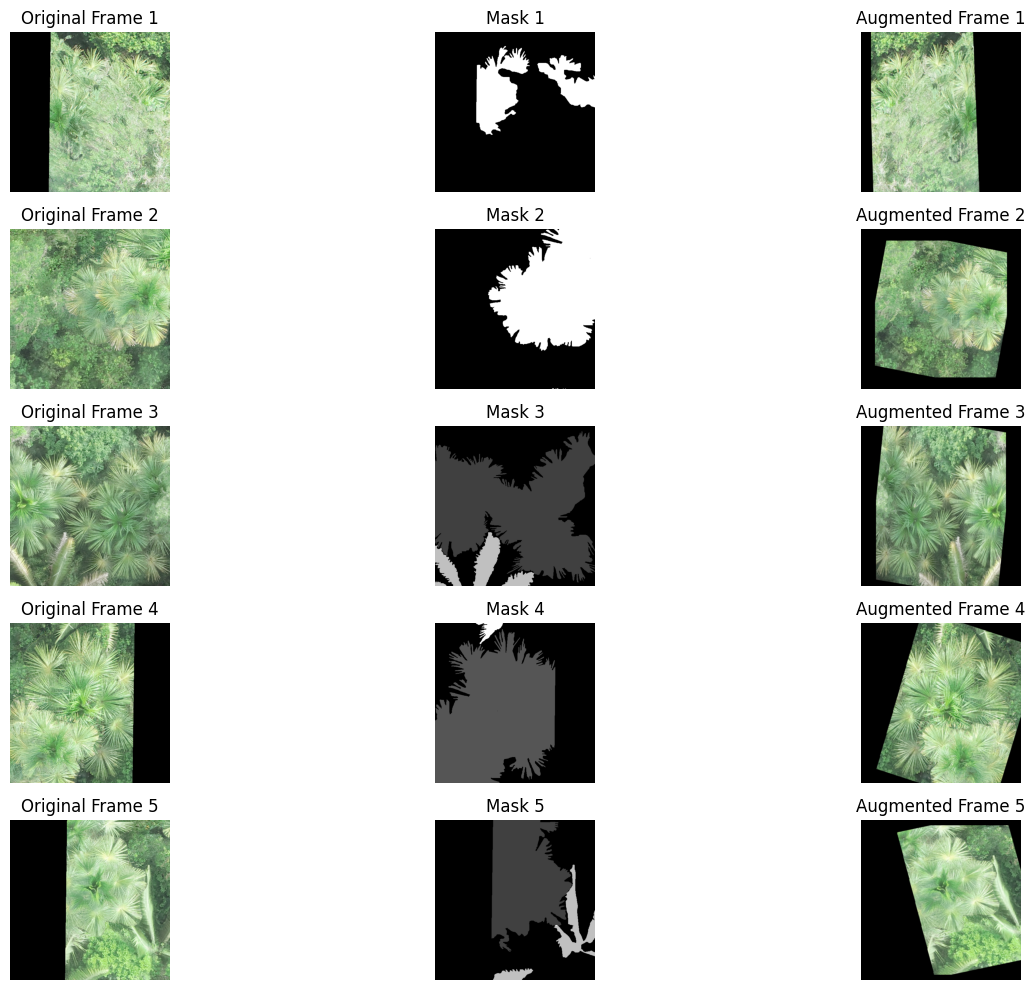

In [16]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),               # Horizontally flip 50% of the images
    iaa.Affine(rotate=(-20, 20)),  # Rotate by -20 to +20 degrees
    iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}) # Zoom in/out by 80-120%
    #add any to try here
])

#lets visualize the augmented frames:
plot_utility.plot_saved_images_with_augmentation(train_frame_path, train_mask_path, seq, num_images=5, delete_after_plot=False)

We applied augmentations designed to simulate various environmental conditions and variations in drone flight. Here's an example of our selection

In [17]:
###Image augmentation
aug = iaa.SomeOf((0, 2), [ # Perform 0 to 2 of the following augmenters
	iaa.MultiplyBrightness((0.8, 1.2)), #change brightness -20 - 20% of the img resembling ilumination conditions
	iaa.MultiplySaturation((0.8, 1.1)), #change saturation 10-150% of the img
	iaa.Fliplr(0.5),		# Flip horizontally 50% of the img
	iaa.Flipud(0.5),		# Flip vertically 50% of the img
	iaa.Affine(rotate=(-20, 20)), # rotate by -20 to +20 degrees
	iaa.Affine(scale={"x": (1, 1), "y": (1, 1)}), # zoom in and out by 80-120%0.8 1.2
	#iaa.imgcorruptlike.Fog(severity=1),	# severity: 1-5 Add blur resembling fog/water droplets
	iaa.Multiply((0.8, 1.3)), # makes images brighter or darker
	iaa.ElasticTransformation(alpha=(0, 2), sigma=0.9), #Alpha 0-5, sigma 0.01-1 resembling artifacts in the mosaics
	iaa.JpegCompression(compression=(60, 70)), #Degrade the quality of images by JPEG-compressing them, 0-100 (100 higher compression)-> different sensors
	iaa.MotionBlur(k=(4,5)), #Blur images in a way that fakes camera or object movements 5x5 to 11x11 kernels -> wind or UAV movement
	])

### 2.3 Model Training - Palm Species Mapping
With our selected augmentations and preprocessed training data in place, we are now ready to begin training the model. This is to show the process, we had more iterations and training data to fit a nice model.

In [28]:
### Model settings
tf.keras.backend.clear_session()
optimizer = tf.keras.optimizers.Adam(
     learning_rate=LR,beta_1=0.9, beta_2=0.999, epsilon=1e-08)#

deeplab_model = Deeplabv3(input_shape=(img_width, img_height, 3), classes=4, OS = 16)
#deeplab_model.load_weights('models/deeplab_keras_weights_palms_test1_20220622_0.003.h5', by_name=True) #Fine tuning: deeplab_keras_model_palms or deeplab_keras_model_palms_all.h5 
#deeplab_model.compile(optimizer=Adam(learning_rate=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss="categorical_crossentropy", metrics=["categorical_accuracy", dice_coef]) #lr=0.003
deeplab_model.compile( loss="categorical_crossentropy", optimizer=optimizer, metrics=["categorical_accuracy", dice_coef]) #lr=0.003


log_dir = log_path + rep + '_'+typetest+'_'+ str(LR) +'_'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=0,write_graph = True)

namemodel=model_path+'deeplab_keras_model_palms_'+rep+'_'+typetest+'_'+str(LR)+ '.h5'
callbacks = [
    #EarlyStopping(patience=10, verbose=1),
    #ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(namemodel, verbose=1, save_best_only=True, save_weights_only=False), 
	tensorboard_callback
	]

# Train the model
train_gen = data_generator(train_frame_path,train_mask_path,train_list, batch_size = BATCH_SIZE,secaug=aug, isdatatrain=True)# secaug=aug isdatatrain=False
val_gen = data_generator(train_frame_path,train_mask_path,val_list, batch_size = BATCH_SIZE,secaug=False,isdatatrain=False)

results = deeplab_model.fit_generator(train_gen,
                          epochs=NO_OF_EPOCHS, 
                          steps_per_epoch = (NO_OF_TRAINING_IMAGES//BATCH_SIZE),
                          validation_data=val_gen, 
                          validation_steps=(NO_OF_VAL_IMAGES//BATCH_SIZE),
						  #class_weight=class_weight
                          callbacks= callbacks
                          )
print("Name of model: ", namemodel, "completed")
tf.keras.backend.clear_session()

2024-10-25 07:51:28.538549: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-10-25 07:51:28.538575: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-10-25 07:51:28.538690: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


num_samples:  15
offset 0
offset 8
1/1 [==============================] - 13s 13s/step - loss: 1.4233 - categorical_accuracy: 0.3308 - dice_coef: 0.3107
Name of model:  /results/Palms_Segment/model/deeplab_keras_model_palms_all_iaa_0.003.h5 completed


In [29]:
###To visualize the training process

#%load_ext tensorboard
#!tensorboard --logdir {log_dir}
#%reload_ext tensorboard #when reloading

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.6.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


This visualization allows us to monitor the progress of training and validation in real-time. We can mitigate overfitting and improve accuracies by incorporating a larger and more diverse dataset.

In [ ]:
###Here we can see some of the augmented images used for the training:
import plot_utility

###Plot the first 3 images generated
plot_utility.plot_images_in_pairs(img_iaa_path, num_images=5)

### 3. Model Prediction - Palm Species Mapping
We will now load our trained model and use it to make predictions on a UAV mosaic that was not included in the training process. To run it with larger images please run script /Palms_Segment/4.predic_raster.py

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model,model_from_json
import cv2
import numpy as np

import os
from Palms_Segment import model
from Palms_Segment import evaluate_data
from Palms_Segment import apply_model as apply_model_dl
from matplotlib.colors import ListedColormap, BoundaryNorm

In [20]:
##Set the paths
data_folder='/data'
output_folder_segment='/results/Palms_Segment/output'
#"/results/PIU-03_1_5_predicted.tif"
os.makedirs(output_folder_segment, exist_ok=True) # Create the directory if it doesn't exist

In [21]:
tf.keras.backend.clear_session()
###Model settings
window_radius = 256
feature_file_list= ['/data/PIU-03_1_5.tif']
internal_window_radius = int(round(window_radius*0.75))

###Load model
model_path="Palms_Segment/model"
model_path = os.path.join(model_path,"modelsavejsonR3")
json_file = open(model_path + '.json','r')
loaded_model_json = json_file.read()
json_file.close()
model_dl = model_from_json(loaded_model_json,custom_objects={'relu6':model.relu6,'BilinearUpsampling':model.BilinearUpsampling,'dice_coef':model.dice_coef  })
model_dl.load_weights(model_path+ '_weights')

###Model application
name_saved = apply_model_dl.apply_semantic_segmentation_argmax(feature_file_list,
                                    output_folder_segment,
                                    model_dl,
                                    window_radius,
                                    internal_window_radius=internal_window_radius,
                                    make_tif=True,
                                    make_png=True,
                                    #response_file_list=response_file_list,
                                    model_assessment=False) #True when having ground truth for validation


Instructions for updating:
Colocations handled automatically by placer.


2024-10-25 08:32:19.046124: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 08:32:19.047580: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


/data/PIU-03_1_5.tif
(256, 2575)
(640, 2575)
(1024, 2575)
(1408, 2575)
(1792, 2575)
(2176, 2575)
(2319, 2575)
(1724, 2575)


[0 1 2 3]


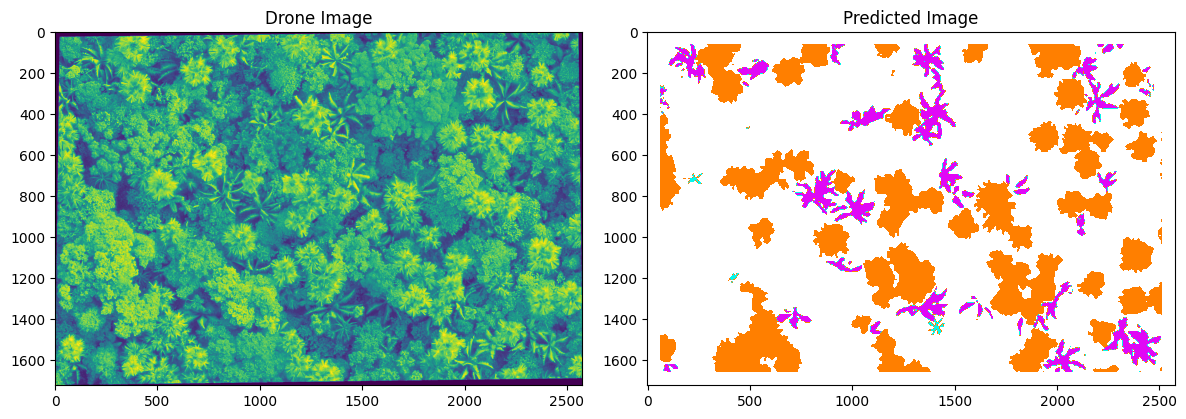

In [22]:
%matplotlib inline
### See the prediction
##Import drone image
feature = gdal.Open('/data/PIU-03_1_5.tif',gdal.GA_ReadOnly)
##Import predicted image
prediction = gdal.Open('/results/Palms_Segment/output/PIU-03_1_5__argmax.tif',gdal.GA_ReadOnly)
# Check if the raster is loaded successfully
if feature is None:
    raise FileNotFoundError("Could not open the raster file. Check the file path.")

if prediction is None:
    raise FileNotFoundError("Could not open the predicted raster file. Check the file path.")

# Get the geotransform to properly locate the raster 
geotransform = feature.GetGeoTransform()

# Read the Green band (Band 2) as an example
green_band = feature.GetRasterBand(2).ReadAsArray().astype(np.uint8)
# Read the predicted image (assume it's also a single band for simplicity)
predicted_image = prediction.GetRasterBand(1).ReadAsArray().astype(np.uint8)
print(np.unique(predicted_image))

# Compute the extent of the raster (left, right, bottom, top) in map coordinates
xmin = geotransform[0]
xmax = xmin + geotransform[1] * feature.RasterXSize
ymax = geotransform[3]
ymin = ymax + geotransform[5] * feature.RasterYSize
extent = [xmin, xmax, ymin, ymax]

# Create a figure to plot the images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the drone image
axes[0].imshow(green_band)
axes[0].set_title('Drone Image')

# Plot the predicted image
colors = ["#ffffff",      # White (0) - Background
          "#ff7f00",       # Orange (1) - Mauritia flexuosa 
          "#08F6EB",       # Cyan (2) - Euterpe precatoria
          "#E008F6"]       # Purple (3) - Oenocarpus bataua
axes[1].imshow(predicted_image, cmap=ListedColormap(colors)) 
axes[1].set_title('Predicted Image')


# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## 4. Model Assessment - Palm Species Mapping
To evaluate our model's performance, we will conduct an accuracy assessment using an independent dataset. This assessment will provide insights into how well the model generalizes to unseen data and helps us identify areas for improvement.

In [26]:
###Computing the classification report 
from Palms_Segment import  prepare_data
prediction_file_list=list(map(lambda x: os.path.join(output_folder_segment,os.path.basename(x).split('.')[0] + '__argmax.tif'), feature_file_list))
response_file_list = ['/data/Palms_merged_PIU-03_1_5_classes.tif'] #y_true
boundary_file_list=['/data/PIU03_ROI_2019.shp']
application_name="test"
prepare_data.model_assessment(prediction_file_list = prediction_file_list,
							response_file_list = response_file_list,
							response_vector_flag=False, #True when working with vectors (only one class)
							boundary_file_list=boundary_file_list, 
							boundary_file_vector_flag=True, #True when using ROIs
							application_name=application_name,
							output_folder = output_folder_segment,
							ignore_projections=True
							)
#Open the saved report
from IPython.display import display, HTML
log_file_path = '/results/Palms_Segment/output/PIU-03_1_5__argmax__CM.logs'
#Read the log
with open(log_file_path, 'r') as file:
    content = file.read()

# Display the content in a scrollable box
display(HTML(f"<pre style='max-height: 300px; overflow-y: scroll;'>{content}</pre>"))


prediction (1724, 2575)
response (1724, 2575)
P_clipped.shape (1, 1622, 2437)
R_clipped.shape (1, 1622, 2437)
True Response [1. 2. 3.]
Y_True.shape (3952814,)
Predict Response [1. 2. 3.]
Y_Pred.shape (3952814,)
Cp 3
ind_array [0 1 2 3]


## 5. Data Preparation - Palm Quantification (Instance Segmentation)


### 5.1 Checking the Data for the Palm Quantification (Instance Segmentation)
This section provides a visual approach to selecting the optimal method for generating training data. For the actual generation of training data, please execute the Python script /Palms_Quant/1.generate_training_data_DWT.py 
For more information regarding the function refer to the SI of [Uncovering ecological patterns with convolutional neural networks](https://www.sciencedirect.com/science/article/pii/S0169534719300862?via%3Dihub) For more information about the DWT: [Deep Watershed Transformation for Instance Segmentation](https://arxiv.org/abs/1611.08303)

Feature array shape: (4, 5773, 6418), dtype: uint8
Response array shape: (5773, 6418), dtype: uint8
Responsegt array shape: (5773, 6418), dtype: uint8


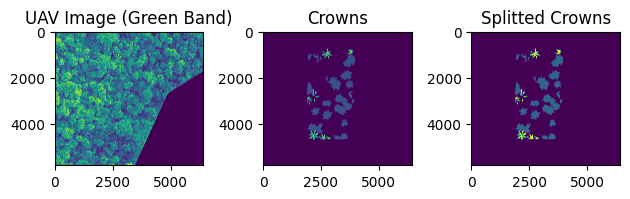

In [27]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

###Load the rasters
# Load the UAV image
feature = gdal.Open('/data/DMM-02_1.tif', gdal.GA_ReadOnly)
feature_array = feature.ReadAsArray().astype(np.uint8)

# Load the crowns (Semantic segmentation input/output)
response = gdal.Open('/results/Palms_Segment/responses_raster/Palms_merged_DMM-02_1_classes.tif', gdal.GA_ReadOnly)
response_array = response.ReadAsArray().astype(np.uint8)

# Load the crowns split
responsegt = gdal.Open('/data/Palms_DMM-02_1_classes.tif', gdal.GA_ReadOnly)
responsegt_array = responsegt.ReadAsArray().astype(np.uint8)

# Print array shapes and data types
print(f"Feature array shape: {feature_array.shape}, dtype: {feature_array.dtype}")
print(f"Response array shape: {response_array.shape}, dtype: {response_array.dtype}")
print(f"Responsegt array shape: {responsegt_array.shape}, dtype: {responsegt_array.dtype}")

# Visualize all the layers
plt.subplot(1, 3, 1)
# Select the green band (assuming it's the 2nd band, which has an index of 1)
plt.imshow(feature_array[1, :, :])  # Use gray colormap for single band visualization
plt.title('UAV Image (Green Band)')

plt.subplot(1, 3, 2)
plt.imshow(response_array)  # 2D array (mask), use a grayscale colormap
plt.title('Crowns')

plt.subplot(1, 3, 3)
plt.imshow(responsegt_array)  # 2D array (mask), use a grayscale colormap
plt.title('Splitted Crowns')

plt.tight_layout()
plt.show()

### 5.2 Data Preparation - Generating the data

This data preparation phase is similar to the process used for training the Palm Detection model but with an additional output. The model will not only learn to recognize the palm itself but will also learn to identify the crown of the palm. For this, we calculate the distance to the edge of the crown and determine the slope angle, which we will refer to as the Ground Truth (GT) angle. The model will learn from this to differentiate single crowns.  In the following scripts, we will work with multiple datasets, enabling us to load several files simultaneously as a list for greater efficiency. Consequently, the variable name for the features will be updated to "Feature_file_list," and similar adjustments will be made for the other datasets.

In this context, the UAV mosaic is designated as the "feature," while the corresponding mask is referred as the "response." This data generation step can be executed using the script at /Palms_Quant/1.generate_training_data_DWT. 

feature_file_list /data/DMM-02_1.tif
('feature shape', (115, 700, 700, 4))
('name_responses shape', (115,))
('depth_maps shape', (115, 700, 700, 1))
('dir_maps shape', (115, 700, 700, 2))
========= Generating  115  Tiles=========


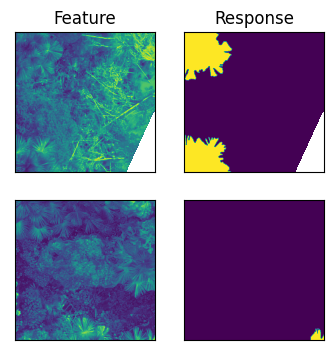

In [28]:
from Palms_Quant import build_training_data
import plot_utility

ignore_projections=True
window_radius = 350
samples_per_response_per_site = 100 #200
feature_file_list = ['/data/DMM-02_1.tif']
responsegt_file_list = ['/data/Palms_DMM-02_1_classes.tif']
response_file_list = ['/results/Palms_Segment/responses_raster/Palms_merged_DMM-02_1_classes.tif']

features,responses,fold_assignments,deep_maps,dir_maps, name_responses = build_training_data.build_semantic_segmentation_training_data_for_DWT(\
                                      window_radius,
                                      samples_per_response_per_site,
                                      feature_file_list,
                                      response_file_list,
                                      responsegt_file_list,
                                      response_vector_flag=False,
                                      responsegt_vector_flag=False,
                                      local_scale_flag='mean',
                                      nodata_maximum_fraction=0.1,
                                      center_random_offset_fraction=0.2,
                                      ignore_projections=ignore_projections,
                                      response_repeats=1 #4
)
#print(features.shape)
#print(responses.shape)

#Let's check the tiles
plot_utility.plot_training_data(features,responses,images_to_plot=2)

Let's check the GT calculated angle with the UAV image

features.shape (115, 700, 700, 4)
gt_responses.shape (115, 700, 700, 1)


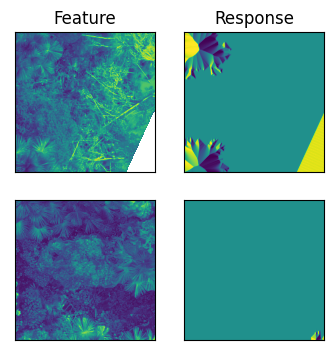

In [30]:
print("features.shape",features.shape)
print("gt_responses.shape",deep_maps.shape)
plot_utility.plot_training_data(features,dir_maps[:,:,:,:1],images_to_plot=2)

The previous function generated the data as temporary NumPy arrays. To ensure efficient storage and facilitate later access, we will save them as compressed NumPy .npz files

In [31]:
def save_dataset(item,feature,response,deep_map,dir_map,dirsave,name):
    #Calc weights
    weight_map=np.zeros(dir_map.shape,dtype=np.float32)
    if(np.sum(response)>0):
        weight=200/np.sqrt(np.sum(response))
        weight_map[response[:,:,0]==1,0]=weight
        weight_map[response[:,:,0]==1,1]=weight
        #print(weight)
    feature_file=dirsave+name+'_'+str(item)+"_feature"
    response_file=dirsave+name+'_'+str(item)+"_response"
    deepmap_file=dirsave+name+'_'+str(item)+"_deepmap"
    dirmap_file=dirsave+name+'_'+str(item)+"_dirmap"
    weightmap_file=dirsave+name+'_'+str(item)+"_weightmap"
    
    np.savez_compressed(feature_file, feature)
    np.savez_compressed(response_file, response)
    np.savez_compressed(deepmap_file, deep_map)
    np.savez_compressed(dirmap_file, dir_map)
    np.savez_compressed(weightmap_file, weight_map)
    
path="/results/Palms_Quant/dataset/npz/"
os.makedirs(path, exist_ok=True)
for item in range(0,features.shape[0]):
	    save_dataset(item,features[item],responses[item],deep_maps[item],dir_maps[item],path,name_responses[item])
print ("***********NPZs saved, check folder", path, "********************")    

***********NPZs saved, check folder /results/Palms_Quant/dataset/npz/ ********************


### 5.3 Splitting our Dataset into Training (80%) and Validation (20%)
To evaluate the accuracy and generalization of our model, we applied an 80/20 split, with 80% of the data used for training and 20% for validation. The npzs stored in the folders were compiled into a list that serves as input for model training. This part can be run using the script /Palms_Quant/2.generate_lists_R.py

In [33]:
import glob
import numpy as np

rasters=[#'AGU-01',
'DMM-02_1',
#'JHU-01_9_10_11_12',
#'NJN-01_4_5',
#'NJN-01_6',
#'PIU-00_1_2_3_4_5',
#'PIU-03_1_5',
#'VAP-01_1_2',
]
imageDir='/results/Palms_Quant/dataset/'
npzlist = glob.glob(imageDir+'npz/*_response.npz')
print(npzlist[4])
print("No Tiles: ",len(npzlist))
list_tiles=[]

def generarlistfromfilter(npzlist):
	list_tiles=[]
	for npz in npzlist:
		npzname=npz.replace('_response.npz','')
		npzm=np.load(npz )
		npzm = (npzm.f.arr_0).astype(int)[:,:]
		list_class=np.unique(npzm)
		#if 1 in list_class and(2 in list_class or 3 in list_class) :
		if 1 in list_class or 2 in list_class or 3 in list_class:
			list_tiles.append(npzname)
	return list_tiles	

def split_train_val(list_tiles):
        ### Split dataset
        TRAINING_SPLIT = 0.8 #80%
        VAL_SPLIT=0.2
        TEST_SPLIT=0.0  # Independent dataset

        it = int(len(list_tiles) * TRAINING_SPLIT)
        iv = int(len(list_tiles) * VAL_SPLIT)
        itt = int(len(list_tiles) * TEST_SPLIT)
        print('it:',it,' - iv',iv,' itt:',itt)

        #n = np.random.permutation(n)

        listtrain=list_tiles[0:it]
        listval=list_tiles[it:]
        return listtrain,listval


def generarlistfromfilter_balanced(listmask):
	list_tiles1=[]
	list_tiles2=[]
	list_tiles3=[]
	for mask in listmask:
		npzname=mask.replace('_response.npz','')
		npzm=np.load(mask )
		npzm = (npzm.f.arr_0).astype(int)[:,:]
		uqclases=np.unique(npzm)
		if 3 in uqclases:
			list_tiles3.append(npzname)
		elif 2 in uqclases:
			list_tiles2.append(npzname)
		elif 1 in uqclases:
			list_tiles1.append(npzname)
		min_size=50 #6000 min size crown allowed, now we have a very small dataset so we reduce it for the example
	print("class 1",len(list_tiles1))
	print("class 2",len(list_tiles2))
	print("class 3",len(list_tiles3))
	print("min_size",min_size)
	np.random.shuffle(list_tiles1)
	np.random.shuffle(list_tiles2)
	np.random.shuffle(list_tiles3)
	list_tiles1=list_tiles1[0:min_size]
	list_tiles2=list_tiles2[0:min_size]
	list_tiles3=list_tiles3[0:min_size]

	listtrain1,listval1=split_train_val(list_tiles1)
	listtrain2,listval2=split_train_val(list_tiles2)
	listtrain3,listval3=split_train_val(list_tiles3)

	b_listtrain = listtrain1+listtrain2+listtrain3
	b_listval= listval1+listval2+listval3
	np.random.shuffle(b_listtrain)
	np.random.shuffle(b_listval)
	return b_listtrain,b_listval


listtrain,listval=generarlistfromfilter_balanced(npzlist[0:10])
print("listtrain",len(listtrain))
print("listval",len(listval))
np.savetxt(imageDir+'Trainlist_balanced_classes.txt', listtrain, delimiter='\\n',fmt='%s') 
np.savetxt(imageDir+'Vallist_balanced_classes.txt', listval, delimiter='\\n',fmt='%s')

/results/Palms_Quant/dataset/npz/DMM-02_1_4.0_112_response.npz
No Tiles:  115
class 1 3
class 2 0
class 3 5
min_size 50
it: 2  - iv 0  itt: 0
it: 0  - iv 0  itt: 0
it: 4  - iv 1  itt: 0
listtrain 6
listval 2


## 6. Model Training - Palm Quantification (Instance Segmentation)
With our training data prepared, we will proceed to train the model using the DWT architecture. This architecture utilizes three inputs: the UAV image (feature), the palm masks (response), and the angle derived from the distance to the border of each palm crown (GT angle). For implementation details, we followed the code available at https://github.com/min2209/dwt. You can also execute the training using the script located at Palms_Quant/E2E_palms/3.TrainDWT.py

In [34]:
from Palms_Quant.E2E_palms.network_init import get_model
from Palms_Quant.E2E_palms.io_utils import *
import tensorflow as tf
from Palms_Quant.E2E_palms.forward import forward_model
from Palms_Quant.E2E_palms.train import train_model
import os

Instructions for updating:
non-resource variables are not supported in the long term


In [35]:
## Parameter Initialization
tf.random.set_seed(0) # Seed for reproducibility

if __name__ == "__main__":
    outputChannels = 16
    savePrefix = "dwt_balanced_v1"
    outputPrefix = "/results/Palms_Quant/model/"
    os.makedirs(outputPrefix, exist_ok=True)
    #pathnpz="../output/e2e/tiles"
    pathnpz=""
    pathnpzlist="/results/Palms_Quant/dataset"
    
    train = True
    tf.keras.backend.clear_session()
    if train:
        batchSize = 5
        learningRate = 5e-6 # usually 5e-6
        wd = 1e-6

        modelWeightPaths = None

        initialIteration = 1

        trainFeeder = Batch_Feeder(dataset="cityscapes", # 0=car, 1=person, 2=rider, 3=motorcycle, 4=bicycle, 5=truck, 6=bus, 7=train
                                           train=train,
                                           batchSize=batchSize,
                                           flip=True, keepEmpty=False, shuffle=True)

        trainFeeder.set_paths(idList=read_ids(pathnpzlist+'/Trainlist_balanced_classes.txt'),
                         imageDir=pathnpz+'/',
                         gtDir=pathnpz+'/',
                         #gtDir='../output/direction_ss/',
                         ssDir=pathnpz+'/')

        valFeeder = Batch_Feeder(dataset="cityscapes",
                                         train=train,
                                         batchSize=batchSize, shuffle=False)

        valFeeder.set_paths(idList=read_ids(pathnpzlist+'/Vallist_balanced_classes.txt'),
                         imageDir=pathnpz+'/',
                         gtDir=pathnpz+'/',
                         #gtDir='../output/direction_ss/',
                         ssDir=pathnpz+'/')

        model = get_model(wd=wd, modelWeightPaths=modelWeightPaths)

        

        train_model(model=model, outputChannels=outputChannels,
                    learningRate=learningRate,
                    trainFeeder=trainFeeder,
                    valFeeder=valFeeder,
                    modelSavePath=outputPrefix, 
                    savePrefix=savePrefix,
                    initialIteration=initialIteration)

    else:
        batchSize = 2
        modelWeightPaths = ["/results/Palms_Quant/model/dwt_onliclases_v5_045.mat"]

        model = get_model(modelWeightPaths=modelWeightPaths)

        feeder = Batch_Feeder(dataset="cityscapes",
                                      train=train,
                                      batchSize=batchSize)

        feeder.set_paths(idList=read_ids(pathnpz+'/test_npz.txt'),#Test_filter_v3.txt
                         imageDir=pathnpz+'/',
                            ssDir=pathnpz+'/')
        outputSavePath="/results/Palms_Quant/output/e2e"
        os.makedirs(outputSavePath, exist_ok=True)
        forward_model(model, feeder=feeder,
                      outputSavePath=outputSavePath)

attempting to build model
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use the `axis` argument instead
built the model
Instructions for updating:
Use `tf.cast` instead.
setting adam optimizer
attempting to run init
completed init
08:53:47 Itr: 1 - val loss: 3.251254, correct: 0.587491
Ejecutando train batch
train batch 6
attempting to run train batch 0
attempting to run train batch 1
attempting to run train batch 2
attempting to run train batch 3
attempting to run train batch 4
attempting to run train batch 5
08:56:55 Itr: 2 - val loss: 3.239195, correct: 0.585781
Ejecutando train batch
train batch 6
attempting to run train batch 0
attempting to run train batch 1
attempting to run train batch 2
attempting to run train batch 3
attempting to run train batch 4
attempting to run

## 7. Model Prediction - Palm Quantification (Instance Segmentation)
Let's apply our trained Deep Watershed Transform model, which enables us to segment individual palm crowns and quantify them.
To run it with more data please run script /Palms_Quant/E2E_palms/4.predict_raster_DWT_all.py

In [42]:
from Palms_Quant.E2E_palms import apply_model as apply_model_dwt

In [43]:
###Parameters for prediction
tf.keras.backend.clear_session()
window_radius = 350
internal_window_radius = int(round(window_radius*0.75))
name_mask_clas = os.path.join(output_folder_segment,name_saved)
#print(name_mask)
mask=[name_mask_clas]
feature_file_list= ['/data/PIU-03_1_5.tif']
roi=[]
modelWeightPaths="Palms_Quant/model"
modelWeightPaths = [os.path.join(modelWeightPaths,"dwt_onliclases_v5_045.mat")] #dwt_palms_pspsnet_v2_030
output_folder_quant='/results/Palms_Quant/output'
os.makedirs(output_folder_quant, exist_ok=True) # Create the directory if it doesn't exist
model = get_model(modelWeightPaths=modelWeightPaths)

name_saved_final, mau, eut, oeno =apply_model_dwt.apply_instance_dwt_optimizado(feature_file_list,
                                    mask,
                                    roi,
                                    output_folder_quant,
                                    model,
                                    window_radius,
                                    internal_window_radius=internal_window_radius,
                                    make_tif=True,
                                    make_png=True)


OUTPUT_RASTER="/results/Palms_Quant/output/PIU-03_1_5_predicted.tif"
out_imag = os.path.join(output_folder_quant,name_saved_final)
os.rename(out_imag, OUTPUT_RASTER)
tf.keras.backend.clear_session()
#print(mau)
# Print the report in a more detailed format
print("----- Class Count Report -----")
print(f"Input File: {OUTPUT_RASTER}")
print("Number of pixels per class:")
print(f"Mauritia flexuosa (Class 1): {mau} palm trees")
print(f"Euterpe precatoria (Class 2): {eut} palm trees")
print(f"Oenocarpus bataua (Class 3): {oeno} palm trees")
print("-----------END---------------")

----- Class Count Report -----
Input File: /results/Palms_Quant/output/PIU-03_1_5_predicted.tif
Number of pixels per class:
Mauritia Flexuosa (Class 1): 57 palm trees
Euterpe Precatoria (Class 2): 0 palm trees
Oenocarpus Bataua (Class 3): 44 palm trees
-----------END---------------


For more information on the prediction process, please refer to the PalmsCNN_Tutorial_Prediction notebook.